In [42]:
import numpy as np
import matplotlib.pyplot as plt
import lib
from importlib import reload

In [43]:
class CG:
    def __init__(self, A, b):
        self.A = A
        self.x = np.zeros_like(b)        
        self.res = np.inf
        self.r = b - self.A(self.x)
        self.d = self.r
        
    def step(self):
        a = self.r.T @ self.r / (self.d.T @ self.A(self.d))
        self.x += a * self.d
        r_new = self.r - a * self.A(self.d)
        self.res = np.sqrt(np.dot(r_new, r_new))
        B = r_new.T @ r_new / (self.r.T @ self.r)
        self.d = r_new + B * self.d
        self.r = r_new

In [44]:
def pointing(nside, direction='both'):
    pixmap = np.mgrid[:nside,:nside]  
    pixmap[1,1::2, :] = pixmap[1,1::2, ::-1]          
    lr = pixmap.reshape(2,-1)         
    ud = np.roll(pixmap,1,axis=0).reshape(2,-1)
    both = np.array([np.concatenate([lr[0], ud[0]]),np.concatenate([lr[1], ud[1]])])
    if direction == 'lr': return lr
    if direction == 'ud': return ud
    else: return both

In [45]:
class Mapmaker:
    def __init__(self, nside, pixels, sampling_rate, baseline_length_seconds, pix_size, ell_cutoff, verbose=False):
        self.baseline_length = baseline_length_seconds * sampling_rate
        self.nside = nside
        self.pixels = pixels
        self.nsamp = len(pixels[0])
        self.verbose=verbose
        self.mask_lf, self.mask_hf = make_dct_mask(nside, pix_size, ell_cutoff)

    def A(self, a):
        return FT(Z(F(a, self.baseline_length), self.pixels, self.nside), self.baseline_length)
    
    def solve(self, y, tol=1e-10, max_iter=100):
        b = FT(Z(y, self.pixels, self.nside, self.mask_hf), self.baseline_length)
        cg = CG(self.A, b)
        
        for i in range(max_iter):
            if cg.res < tol: break
            cg.step()
            cg.i = i+1
            if self.verbose:
                print(f'Iter {cg.i}, Residual: {cg.res}')
        
        print(f'Residual: {cg.res} in {cg.i} iterations')
        return cg.x

In [212]:
from scipy.fft import dct, idct

def P(m, pixels):
    return m[pixels[0], pixels[1]]

def PT(y, pixels, nside):
    point_flat = np.ravel_multi_index(pixels, (nside, nside))
    m = np.bincount(point_flat, y, minlength=nside**2)
    m = m.reshape(nside, nside)
    return m

def inv_DPPD(pixels, nside):
    nsamp = len(pixels[0])
    hits = PT(np.ones(nsamp), pixels, nside)
    return hits

def DCT_matrix(N):
    D = dct(np.eye(N), axis=0)
    return np.kron(D, D)

def iDCT_matrix(N):
    D = idct(np.eye(N), axis=0)
    return np.kron(D, D)

def make_dct_mask(nside, pix_size, ell_cutoff):
    x = np.linspace(0, 1, nside)
    X, Y = np.meshgrid(x, x)
    mask_lf = np.sqrt(X**2 + Y**2)
    
    pix_to_rad = pix_size/60 * np.pi/180
    ell_scale_factor = np.pi/ pix_to_rad 
    mask_lf *= ell_scale_factor 
    
    mask_lf[mask_lf > ell_cutoff] = 0
    mask_lf[mask_lf != 0] = 1
    mask_lf[0][0] = 1

    mask_hf = 1 - mask_lf
    return mask_lf, mask_hf

def D_inv(m, mask):    
    D_inv = iDCT_matrix(nside)
    kept = np.where(mask.flatten()==1)[0]
    
    D_inv = D_inv[:, kept]
    
    return D_inv @ m

def D_inv_T(y, mask):
    D_inv = iDCT_matrix(nside)
    kept = np.where(mask.flatten()==1)[0]
    
    D_inv = D_inv[:, kept]
    
    return D_inv.T @ y
    

def Z(y, pixels, nside, mask):
    m = PT(y, pixels, nside)
    m = D_inv_T(m, mask)
    m /= inv_DPPD(pixels, nside)
    proj = P(m, pixels)
    return y - proj 

def F(a, baseline_length):
    result = [baseline_length*[i] for i in a]
    return np.concatenate(result)[:nsamp]

def FT(y, baseline_length):
    rem = len(y) % baseline_length
    if rem != 0:
        y = np.pad(y, (0, baseline_length - rem))
    return np.sum(y.reshape(-1, baseline_length), axis=1)


In [217]:
nside = 64
pixels = lib.pointing(nside, 'both')
nsamp = len(pixels[0])
rate = 10
seconds = nsamp / rate
times = np.linspace(0, seconds, nsamp)
baseline_length_seconds = 10
baseline_length = baseline_length_seconds * rate

print(f'Total samples: {nsamp}')
print(f'Total time: {seconds}')

pix_size = 10 #arcmin
ell_cutoff = 200
ell = np.arange(0, 180/pix_size*60)
Dl = np.ones_like(ell)
# plt.plot(ell, Dl)
# plt.grid()

Total samples: 8192
Total time: 819.2


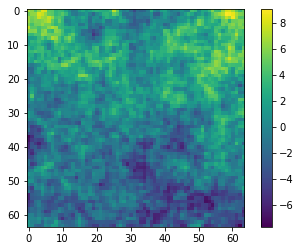

In [214]:
reload(lib)
m = lib.generate_map(Dl, nside, pix_size)
m -= np.mean(m)
plt.imshow(m)
plt.colorbar()

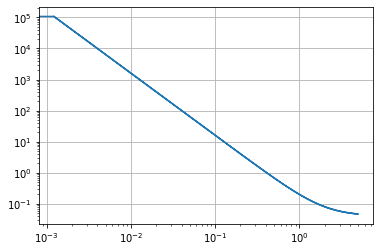

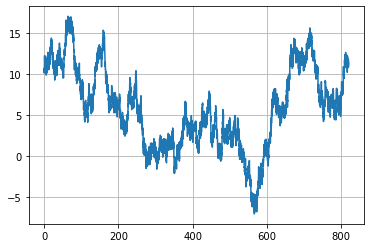

In [215]:
reload(lib)
noise = lib.generate_noise(nsamp, 1/rate, fknee=2, alpha=2, sigma=2e-1)
plt.plot(times, noise)
plt.grid()

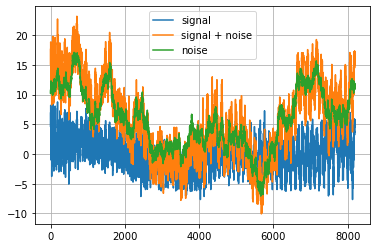

In [216]:
signal = P(m, pixels)
y = signal + noise
plt.plot(signal, label='signal')
plt.plot(y, label='signal + noise')
plt.plot(noise, label='noise')
plt.grid()
plt.legend()

In [34]:
mapmaker = Mapmaker(nside, pixels, rate, baseline_length_seconds, pix_size, ell_cutoff)
a = mapmaker.solve(y-D_inv(m), tol=1e-12, max_iter=100)

Residual: 6.051854440349415e-13 in 45 iterations


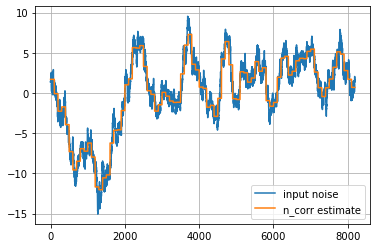

In [35]:
plt.plot(noise - np.mean(noise), label='input noise')
plt.plot(F(a, baseline_length) - np.mean(F(a, baseline_length)), label='n_corr estimate')
plt.grid()
plt.legend()

In [36]:
m_destripe = PT(y - F(a, baseline_length), pixels, nside)/inv_PT_P(pixels, nside) #Destriping solution

#remove monopole
m_destripe -= np.mean(m_destripe)

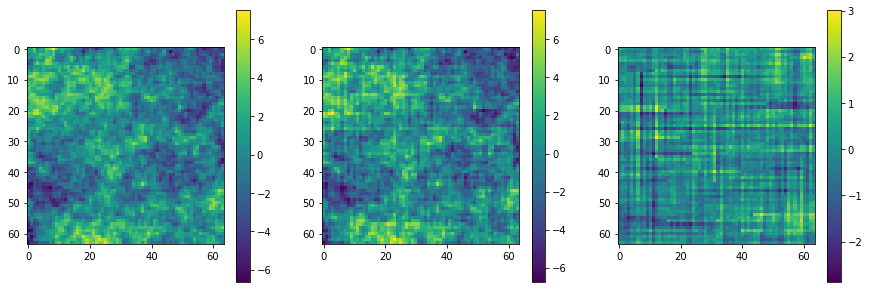

Input map std: 2.2188713362095425
Solved map std: 2.344429932786643


In [37]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))

input_map = axes[0].imshow(m)
output_map = axes[1].imshow(m_destripe.reshape(nside, nside))
diff_map = axes[2].imshow(m - m_destripe.reshape(nside, nside))

fig.colorbar(input_map, ax=axes[0])
fig.colorbar(output_map, ax=axes[1])
fig.colorbar(diff_map, ax=axes[2])

plt.show()
print(f'Input map std: {np.std(m)}')
print(f'Solved map std: {np.std(m_destripe)}')